In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import os
import statistics as stats

# Read all CSV files and store them in the list with their filenames
dfs=[]
for i in range(1,21):
    file=f"latest2/ch{i}.csv"
    df = pd.read_csv(file,skiprows=20)
    # Ensure x and y values are numeric
    df.iloc[:, 0] = pd.to_numeric(df.iloc[:, 0], errors='coerce')  # Ensure x values are numeric (Time)
    df.iloc[:, 1] = pd.to_numeric(df.iloc[:, 1], errors='coerce')  # Ensure y values are numeric (CH1)
    df.iloc[:, 2] = pd.to_numeric(df.iloc[:, 2], errors='coerce')  # Ensure y values are numeric (CH3)
    df.iloc[:, 3] = pd.to_numeric(df.iloc[:, 3], errors='coerce')  # Ensure y values are numeric (CH4)
    dfs.append((df, os.path.basename(file)))  # Store the reversed DataFrame with its filename
print(dfs)

[(             TIME       CH1       CH3       CH4
0   -5.600000e-09  0.053169  0.039478 -0.007672
1   -5.200000e-09  0.053166  0.039452 -0.007656
2   -4.800000e-09  0.053100  0.039475 -0.007609
3   -4.400000e-09  0.053119  0.039484 -0.007703
4   -4.000000e-09  0.053209  0.039486 -0.007672
..            ...       ...       ...       ...
245  9.240000e-08  0.154747  0.074534 -0.040859
246  9.280000e-08  0.154613  0.074527 -0.041313
247  9.320000e-08  0.154628  0.074534 -0.040438
248  9.360000e-08  0.154497  0.074483 -0.040844
249  9.400000e-08  0.154350  0.074447 -0.040844

[250 rows x 4 columns], 'ch1.csv'), (             TIME       CH1       CH3       CH4
0   -5.600000e-09  0.053109  0.039445 -0.007953
1   -5.200000e-09  0.053150  0.039430 -0.007766
2   -4.800000e-09  0.053072  0.039436 -0.007859
3   -4.400000e-09  0.053128  0.039461 -0.007719
4   -4.000000e-09  0.053181  0.039470 -0.007750
..            ...       ...       ...       ...
245  9.240000e-08  0.154703  0.074578 -0.041297


In [2]:
print("Filename:",dfs[0][1])
print(dfs[0][0])

Filename: ch1.csv
             TIME       CH1       CH3       CH4
0   -5.600000e-09  0.053169  0.039478 -0.007672
1   -5.200000e-09  0.053166  0.039452 -0.007656
2   -4.800000e-09  0.053100  0.039475 -0.007609
3   -4.400000e-09  0.053119  0.039484 -0.007703
4   -4.000000e-09  0.053209  0.039486 -0.007672
..            ...       ...       ...       ...
245  9.240000e-08  0.154747  0.074534 -0.040859
246  9.280000e-08  0.154613  0.074527 -0.041313
247  9.320000e-08  0.154628  0.074534 -0.040438
248  9.360000e-08  0.154497  0.074483 -0.040844
249  9.400000e-08  0.154350  0.074447 -0.040844

[250 rows x 4 columns]


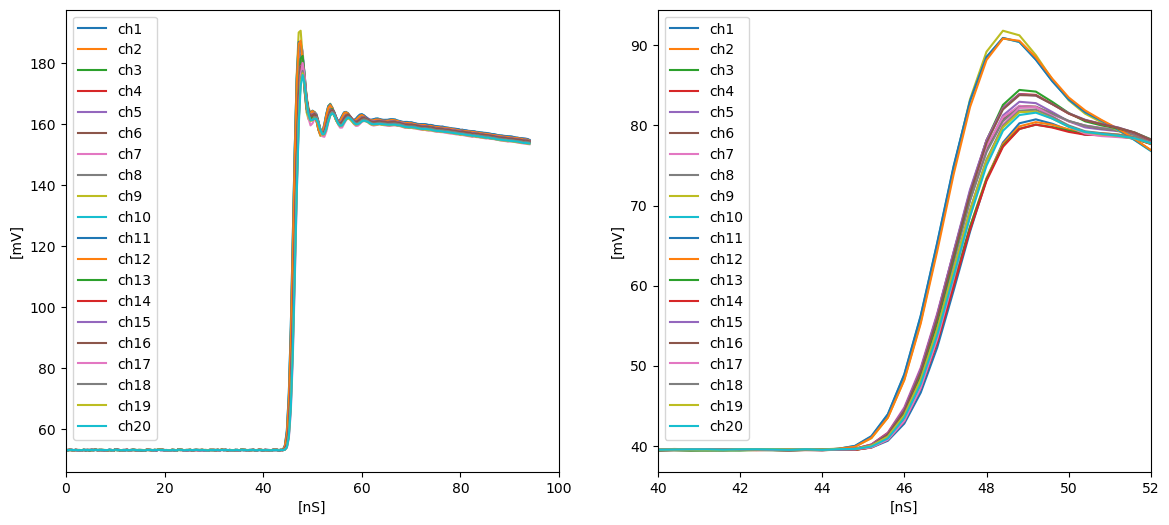

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for i in range(len(dfs)):
    ax[0].plot(dfs[i][0].iloc[:, 0]*1e9, dfs[i][0].iloc[:, 1]*1000,label=dfs[i][1][:-4])
    ax[1].plot(dfs[i][0].iloc[:, 0]*1e9, dfs[i][0].iloc[:, 2]*1000,label=dfs[i][1][:-4])
#ax[0].plot(dfs[0][0].iloc[:, 0], dfs[0][0].iloc[:, 2], color='blue', linestyle='-', label="$\\theta=0$\u00B0 (Vertical Polarizer)")
ax[0].set_xlim(0,100)
ax[1].set_xlim(40,52)
ax[0].set_xlabel("[nS]")
ax[1].set_xlabel("[nS]")
ax[0].set_ylabel("[mV]")
ax[1].set_ylabel("[mV]")
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')

In [4]:
def getPeakIndex(data):
    peak=0
    peak_i=0
    for i in range(len(data)):
        if data[i]>peak:
            peak=data[i]
            peak_i=i
    return peak_i

def getPedestal(data):
    avg=0
    d=int(len(data)/10)
    for i in range(d):
        avg+=data[i]
    return avg/d

def getCrossingTime(time,data,thresh):
    over=0 # first index where data crosses threshold
    under=0 # index before crossing threshold 
    for i in range(len(data)):
        if data[i]>thresh:
            over=i
            under=i-1
            break
    #print(under,over)
    m=(data[over]-data[under])/(time[over]-time[under])
    cross_time=time[under]+((thresh-data[under])/m)
    #print(time[under]*1e9,round(cross_time*1e9,2),time[over]*1e9)
    return cross_time

def getDelayTime(time,data,data2,threshPC):
    peak_i=getPeakIndex(data)
    ped=getPedestal(data)
    amp=data[peak_i]-ped
    thresh=ped+amp*threshPC/100
    t=getCrossingTime(time,data,thresh)
    peak_i=getPeakIndex(data2)
    ped=getPedestal(data2)
    amp=data2[peak_i]-ped
    thresh=ped+amp*threshPC/100
    t2=getCrossingTime(time,data2,thresh)
    return t-t2


def getRiseTime(time,data,threshLowPC,threshHighPC):
    peak_i=getPeakIndex(data)
    ped=getPedestal(data)
    amp=data[peak_i]-ped
    threshLow=ped+amp*threshLowPC/100
    threshHigh=ped+amp*threshHighPC/100
    tLow=getCrossingTime(time,data,threshLow)
    tHigh=getCrossingTime(time,data,threshHigh)
    rt=1e9*(tHigh-tLow)
    return round(rt,3)

print("CASB Rise Time Results")
print("250 MHz Scope")
print("Baseline Restored Unity Analog Sum")
print("-----------------------------------------------------")
print("      U 90-10 [ns]      Attn 80-20 [ns]      Delay [ps] ")
print("-----------------------------------------------------")
delays=[]
delays_attn=[]
for i in range(len(dfs)):
    delay=1e9*getDelayTime(dfs[i][0].iloc[:,0],dfs[i][0].iloc[:,1],dfs[i][0].iloc[:,3],50)
    delays.append(delay)
    delay_attn=1e9*getDelayTime(dfs[i][0].iloc[:,0],dfs[i][0].iloc[:,2],dfs[i][0].iloc[:,3],50)
    delays_attn.append(delay_attn)
base=min(delays)
base_attn=min(delays_attn)
for i in range(len(dfs)):
    delays[i]=1e3*(delays[i]-base)
    delays_attn[i]=1e3*(delays_attn[i]-base_attn)
rt90=[]
rt90_attn=[]
for i in range(len(dfs)):
    rt9010=getRiseTime(dfs[i][0].iloc[:,0],dfs[i][0].iloc[:,1],10,90)
    rt90.append(rt9010)
    rt9010_attn=getRiseTime(dfs[i][0].iloc[:,0],dfs[i][0].iloc[:,2],10,90)
    rt90_attn.append(rt9010_attn)
    # can only calculate delay with 800 ps samples
    print(f"CH{i+1:<6} {rt9010:.3f} {rt9010_attn:>{15}.3f} {delays[i]:>{20}.3f} {delays_attn[i]:>{30}.3f}")
print("-----------------------------------------------------")
print(f"AVG {sum(rt90)/len(rt90):>{10}.3f} {sum(rt90_attn)/len(rt90_attn):>{15}.3f}")
print(f"STD {stats.stdev(rt90):>{10}.3f} {stats.stdev(rt90_attn):>{15}.3f}")
print(f"MAX {max(rt90):>{10}.3f} {max(rt90_attn):>{15}.3f}")
print(f"MIN {min(rt90):>{10}.3f} {min(rt90_attn):>{15}.3f}")


CASB Rise Time Results
250 MHz Scope
Baseline Restored Unity Analog Sum
-----------------------------------------------------
      U 90-10 [ns]      Attn 80-20 [ns]      Delay [ps] 
-----------------------------------------------------
CH1      1.791           2.207              392.839                        450.607
CH2      1.817           2.246              311.507                        390.002
CH3      1.807           2.245              304.103                        382.525
CH4      1.803           2.236              323.140                        400.180
CH5      1.790           2.174              294.719                        323.882
CH6      1.804           2.222              228.965                        274.873
CH7      1.799           2.220              200.240                        245.610
CH8      1.789           2.204              243.194                        290.284
CH9      1.722           2.121               75.073                         59.288
CH10     1.744  

<function matplotlib.pyplot.show(close=None, block=None)>

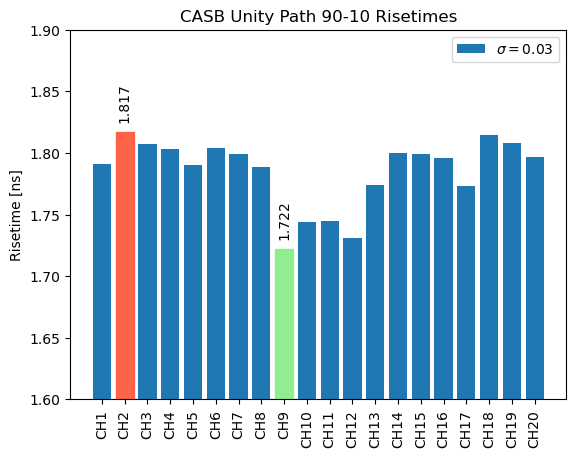

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
channels = ['CH1','CH2','CH3','CH4','CH5','CH6','CH7','CH8','CH9','CH10','CH11','CH12','CH13','CH14','CH15','CH16','CH17','CH18','CH19','CH20']

std_dev=np.std(rt90)
# Find the index of the bar with the lowest value
min_index = rt90.index(min(rt90))
max_index = rt90.index(max(rt90))
# Create bar plot
bars = plt.bar(channels,rt90)
# Set the color of the bar with the lowest value to gold
bars[min_index].set_color('lightgreen')
bars[max_index].set_color('tomato')
# Add value label on top of the bar with the lowest value, rotated 90 degrees
plt.text(min_index, rt90[min_index]+0.01, str(rt90[min_index]), ha='center', rotation=90)
plt.text(max_index, rt90[max_index]+0.01, str(rt90[max_index]), ha='center', rotation=90)
# Rotate the x-axis labels
plt.xticks(rotation=90)
plt.ylim(1.6,1.9)
plt.ylabel('Risetime [ns]')
plt.title('CASB Unity Path 90-10 Risetimes')

# Add standard deviation to the legend
plt.legend([f'$\\sigma= {std_dev:.2f}$'])
# Show the plot
plt.show



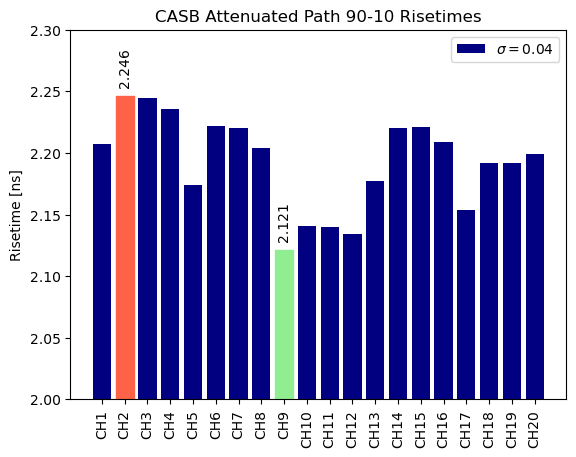

In [6]:
std_dev=np.std(rt90_attn)
# Find the index of the bar with the lowest value
min_index = rt90_attn.index(min(rt90_attn))
max_index = rt90_attn.index(max(rt90_attn))
# Create bar plot
bars2 = plt.bar(channels,rt90_attn,color='navy')
# Set the color of the bar with the lowest value to gold
bars2[min_index].set_color('lightgreen')
bars2[max_index].set_color('tomato')
# Add value label on top of the bar with the lowest value, rotated 90 degrees
plt.text(min_index, rt90_attn[min_index]+0.01, str(rt90_attn[min_index]), ha='center', rotation=90)
plt.text(max_index, rt90_attn[max_index]+0.01, str(rt90_attn[max_index]), ha='center', rotation=90)
# Rotate the x-axis labels
plt.xticks(rotation=90)
plt.ylim(2,2.3)
plt.ylabel('Risetime [ns]')
plt.title('CASB Attenuated Path 90-10 Risetimes')

# Add standard deviation to the legend
plt.legend([f'$\\sigma= {std_dev:.2f}$'])
# Show the plot
plt.show()

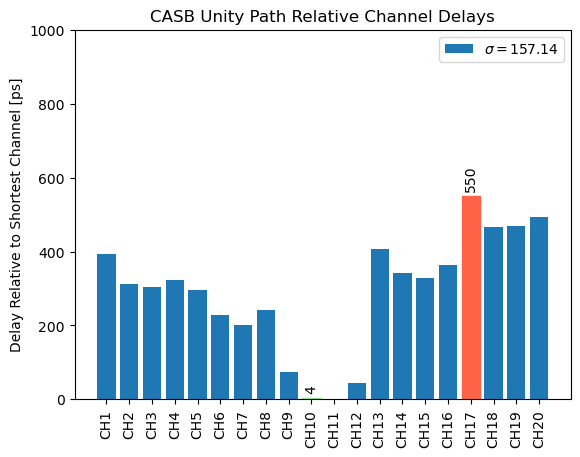

In [9]:

# Sample data
std_dev=np.std(delays)
# Find the index of the bar with the lowest value
min_index = delays.index(min(delays))
# Temporarily replace the lowest value with a large number (infinity)
temp_values = delays.copy()  # Make a copy to avoid modifying the original list
temp_values[min_index] = float('inf')  # Set the lowest value to infinity
# Find the index of the second-lowest value
min_index = temp_values.index(min(temp_values))
max_index = delays.index(max(delays))
# Create bar plot
bars = plt.bar(channels,delays)
# Set the color of the bar with the lowest value to gold
bars[min_index].set_color('lightgreen')
bars[max_index].set_color('tomato')
# Add value label on top of the bar with the lowest value, rotated 90 degrees
plt.text(min_index, delays[min_index]+20, f"{delays[min_index]:.0f}", ha='center', rotation=90)
plt.text(max_index, delays[max_index]+20, f"{delays[max_index]:.0f}", ha='center', rotation=90)
# Rotate the x-axis labels
plt.xticks(rotation=90)
plt.ylabel('Delay Relative to Shortest Channel [ps]')
plt.title('CASB Unity Path Relative Channel Delays')
plt.ylim(0,1000)
# Add standard deviation to the legend
plt.legend([f'$\\sigma= {std_dev:.2f}$'])
# Show the plot
plt.show()

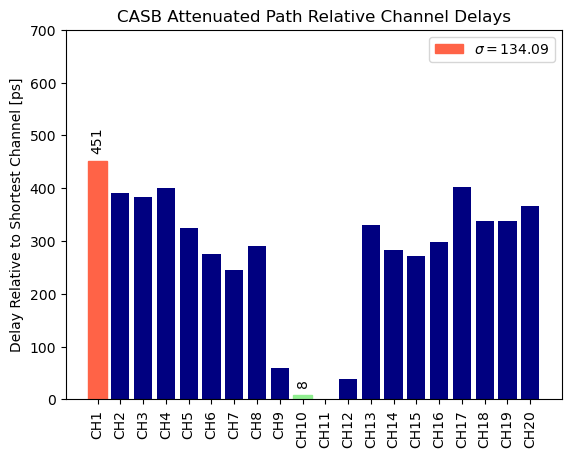

In [8]:

# Sample data
std_dev=np.std(delays_attn)
# Find the index of the bar with the lowest value
min_index = delays_attn.index(min(delays_attn))
# Temporarily replace the lowest value with a large number (infinity)
temp_values = delays_attn.copy()  # Make a copy to avoid modifying the original list
temp_values[min_index] = float('inf')  # Set the lowest value to infinity
# Find the index of the second-lowest value
min_index = temp_values.index(min(temp_values))
max_index = delays_attn.index(max(delays_attn))
# Create bar plot
bars = plt.bar(channels,delays_attn,color='navy')
# Set the color of the bar with the lowest value to gold
bars[min_index].set_color('lightgreen')
bars[max_index].set_color('tomato')
# Add value label on top of the bar with the lowest value, rotated 90 degrees
plt.text(min_index, delays_attn[min_index]+20, f"{delays_attn[min_index]:.0f}", ha='center', rotation=90)
plt.text(max_index, delays_attn[max_index]+20, f"{delays_attn[max_index]:.0f}", ha='center', rotation=90)
# Rotate the x-axis labels
plt.xticks(rotation=90)
plt.ylabel('Delay Relative to Shortest Channel [ps]')
plt.title('CASB Attenuated Path Relative Channel Delays')
plt.ylim(0,700)
# Add standard deviation to the legend
plt.legend([f'$\\sigma= {std_dev:.2f}$'])
# Show the plot
plt.show()

In [77]:
def getPeakIndex(data):
    peak=0
    peak_i=0
    for i in range(len(data)):
        if data[i]>peak:
            peak=data[i]
            peak_i=i
    return peak_i

def getPedestal(data,r=False):
    avg=0
    d=int(len(data)/10)
    if r==True:
        c=0
        for i in range(len(data)):
            if (i<10):
                avg+=data[i]
                c+=1
        return avg/c
    else:
        for i in range(d):
            avg+=data[i]
        return avg/d

def getAmplitude(data,r=False):
    if r==True:
        ped=getPedestal(data,r=True)
    else:
        ped=getPedestal(data)
    peak_i=getPeakIndex(data)
    amp=data[peak_i+10]-ped
    return amp

unity_gain=[]
attn_gain=[]
for i in range(len(dfs)):
    unity_amp=getAmplitude(dfs[i][0].iloc[:,1])
    attn_amp=getAmplitude(dfs[i][0].iloc[:,2])
    pulser_amp=getAmplitude(dfs[i][0].iloc[:,3],r=True)
    #print(unity_amp,attn_amp,pulser_amp)
    unity_gain.append(2*unity_amp/pulser_amp)
    attn_gain.append(2*attn_amp/pulser_amp)

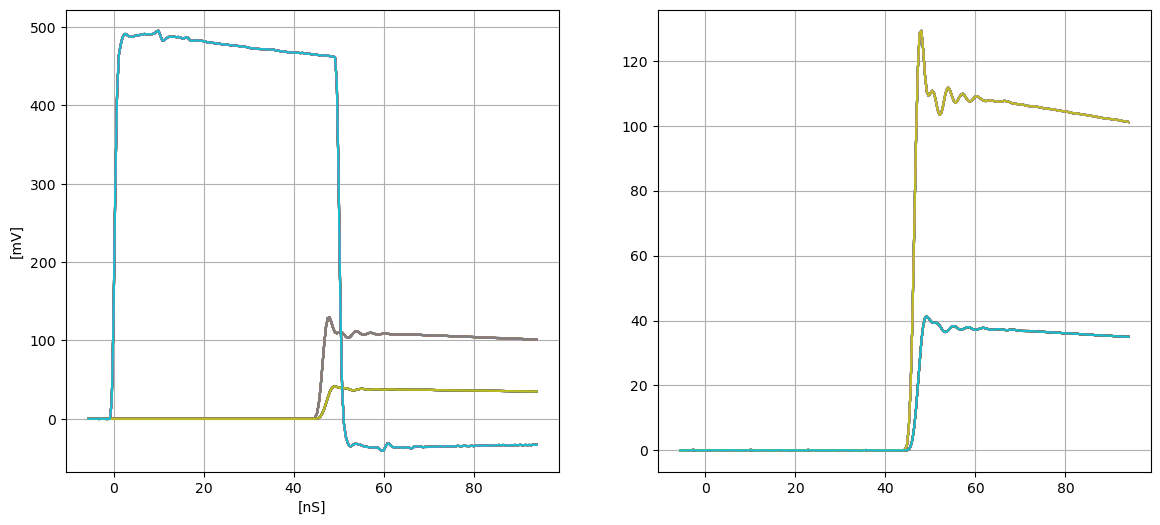

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for i in range(len(dfs)):
    ax[0].plot(dfs[0][0].iloc[:, 0]*1e9, (dfs[0][0].iloc[:, 1]-getPedestal(dfs[0][0].iloc[:, 1]))*1000,label=dfs[0][1][:-4])
    ax[0].plot(dfs[0][0].iloc[:, 0]*1e9, (dfs[0][0].iloc[:, 2]-getPedestal(dfs[0][0].iloc[:, 2]))*1000,label=dfs[0][1][:-4])
    ax[0].plot(dfs[0][0].iloc[:, 0]*1e9, (dfs[0][0].iloc[:, 3]-getPedestal(dfs[0][0].iloc[:, 3],r=True))*1000,label=dfs[0][1][:-4])
    ax[1].plot(dfs[0][0].iloc[:, 0]*1e9, (dfs[0][0].iloc[:, 1]-getPedestal(dfs[0][0].iloc[:, 1]))*1000,label=dfs[0][1][:-4])
    ax[1].plot(dfs[0][0].iloc[:, 0]*1e9, (dfs[0][0].iloc[:, 2]-getPedestal(dfs[0][0].iloc[:, 2]))*1000,label=dfs[0][1][:-4])
#ax[0].plot(dfs[0][0].iloc[:, 0], dfs[0][0].iloc[:, 2], color='blue', linestyle='-', label="$\\theta=0$\u00B0 (Vertical Polarizer)")
#ax[0].set_xlim(0,100)
#ax[1].set_xlim(40,60)
ax[0].set_xlabel("[nS]")
#ax[1].set_xlabel("[nS]")
ax[0].set_ylabel("[mV]")
#ax[1].set_ylabel("[mV]")
#ax[0].legend(loc='upper left')
#ax[1].legend(loc='upper left')
ax[0].grid()
ax[1].grid()







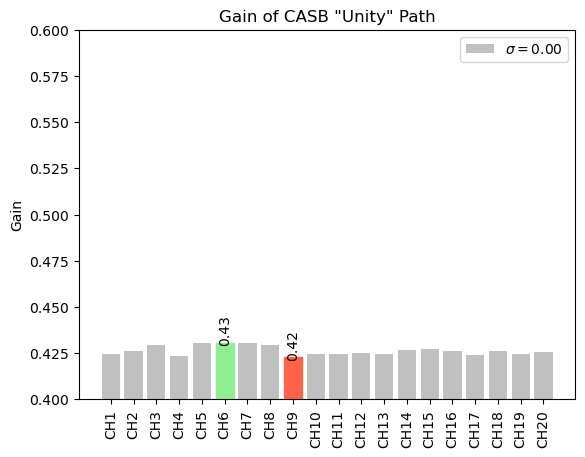

In [79]:
std_dev=np.std(unity_gain)
min_index = unity_gain.index(min(unity_gain))
max_index = unity_gain.index(max(unity_gain))
# Create bar plot
bars = plt.bar(channels,unity_gain,color='silver')
# Set the color of the bar with the lowest value to gold
bars[min_index].set_color('tomato')
bars[max_index].set_color('lightgreen')
# Add value label on top of the bar with the lowest value, rotated 90 degrees
plt.text(min_index, unity_gain[min_index], f"{unity_gain[min_index]:.2f}", ha='center', rotation=90)
plt.text(max_index, unity_gain[max_index], f"{unity_gain[max_index]:.2f}", ha='center', rotation=90)
# Rotate the x-axis labels
plt.xticks(rotation=90)
plt.ylabel('Gain')
plt.title('Gain of CASB "Unity" Path')
# Add standard deviation to the legend
plt.legend([f'$\\sigma= {std_dev:.2f}$'])
plt.ylim(0.4,0.6)
# Show the plot
plt.show()

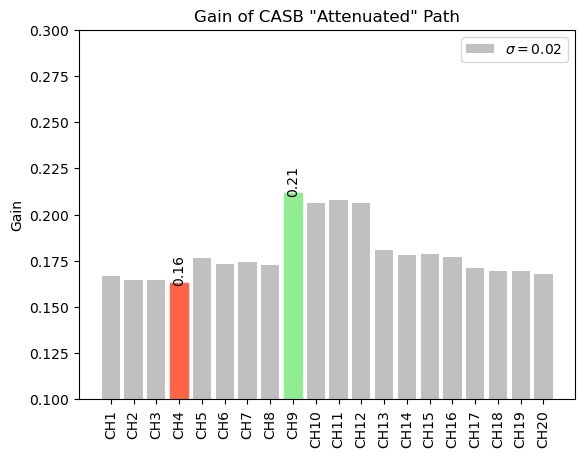

In [60]:
std_dev=np.std(attn_gain)
min_index = attn_gain.index(min(attn_gain))
max_index = attn_gain.index(max(attn_gain))
# Create bar plot
bars = plt.bar(channels,attn_gain,color='silver')
# Set the color of the bar with the lowest value to gold
bars[min_index].set_color('tomato')
bars[max_index].set_color('lightgreen')
# Add value label on top of the bar with the lowest value, rotated 90 degrees
plt.text(min_index, attn_gain[min_index], f"{attn_gain[min_index]:.2f}", ha='center', rotation=90)
plt.text(max_index, attn_gain[max_index], f"{attn_gain[max_index]:.2f}", ha='center', rotation=90)
# Rotate the x-axis labels
plt.xticks(rotation=90)
plt.ylabel('Gain')
plt.title('Gain of CASB "Attenuated" Path')
# Add standard deviation to the legend
plt.legend([f'$\\sigma= {std_dev:.2f}$'])
plt.ylim(0.1,0.3)
# Show the plot
plt.show()